# Salary Prediction from Job Descrption

### 1. Define the problem.

I am looking to predict the salary of jobs given a job description mentioning different factors such as job type, degree and major required, industry, years experience, and distance from the nearest city. 

# Part 2- Discover

### Import packages and load in the data.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

train_features = pd.read_csv('/Users/schottmadison/DSDJ/data_salary_prediction/data/train_features.csv')
train_salaries = pd.read_csv('/Users/schottmadison/DSDJ/data_salary_prediction/data/train_salaries.csv')

### Examine the data to see columns, dtypes, and lengths.

In [4]:
train_features.head()
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [5]:
train_salaries.head()
train_salaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
jobId     1000000 non-null object
salary    1000000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


### Merge the datasets to make it easier to explore further.

In [6]:
training_data = pd.merge(train_features, train_salaries, how='outer', on='jobId')

In [7]:
training_data.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


### 2. Explore and clean the data. 

### Use describe to observe the min, max, and mean for numeric columns.

In [215]:
training_data.describe()

,yearsExperience,milesFromMetropolis,salary
count,1000000.000000,1000000.000000,1000000.000000
mean,11.992386,49.529260,116.061818
std,7.212391,28.877733,38.717936
min,0.000000,0.000000,0.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


### Observe the count, unique values, and frequency of values in the Job ID and Company ID columns

In [216]:
training_data.describe(include = ['O'])

,jobId,companyId
count,1000000,1000000
unique,1000000,63
top,JOB1362684408639,COMP39
freq,1,16193


### Check for null values in columns.

In [8]:
training_data.isna().sum()

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64

### Check for duplicated values.

In [98]:
training_data.duplicated().sum()

0

### Plot the target variable (salary).

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


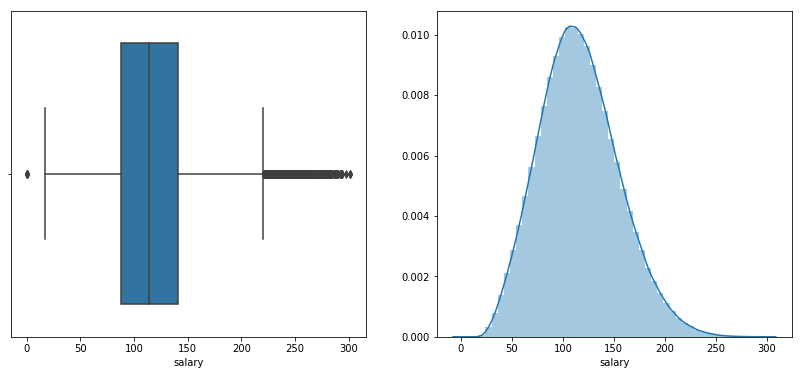

In [110]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.boxplot(training_data.salary)
plt.subplot(1,2,2)
sns.distplot(training_data.salary)
plt.show()

### Check to see where salary is $0 since it is not possible for a job to not pay anything.

In [8]:
training_data[training_data['salary']==0]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


### Remove the values from the training data that have a salary of $0 so it does not affect the model's predictions.
### It is most likely that this value was incorrectly entered or not available.

In [9]:
cleaned_training_data = training_data[training_data.salary != 0]

### Calculate the IQR and upper quartile to see if the very high salaries make sense in their context.

In [197]:
salary_stats = cleaned_training_data.salary.describe()
IQR = salary_stats['75%']-salary_stats['25%']
upper_quartile = salary_stats['75%'] + (IQR * 1.5)
print('Upper quartile:', upper_quartile)

cleaned_training_data[cleaned_training_data['salary'] > upper_quartile]
cleaned_training_data.loc[cleaned_training_data['salary'] > upper_quartile, 'jobType'].value_counts()
cleaned_training_data.loc[(cleaned_training_data['jobType'] == 'JUNIOR') & (cleaned_training_data['salary'] > upper_quartile)]

# these high salaries seem to be reasonable for those in the Junior position since most have higher degrees, 
# many years experience, and are in industries with lots of money

Upper quartile: 220.5


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
1222,JOB1362684408909,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225
27710,JOB1362684435397,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,3,246
31355,JOB1362684439042,COMP45,JUNIOR,DOCTORAL,COMPSCI,FINANCE,24,0,225
100042,JOB1362684507729,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23,8,248
160333,JOB1362684568020,COMP18,JUNIOR,DOCTORAL,BUSINESS,FINANCE,22,3,223
189582,JOB1362684597269,COMP32,JUNIOR,DOCTORAL,BUSINESS,OIL,24,11,221
214606,JOB1362684622293,COMP47,JUNIOR,MASTERS,BUSINESS,FINANCE,22,4,222
303778,JOB1362684711465,COMP51,JUNIOR,MASTERS,ENGINEERING,WEB,24,2,226
348354,JOB1362684756041,COMP56,JUNIOR,DOCTORAL,ENGINEERING,OIL,23,25,226
427593,JOB1362684835280,COMP54,JUNIOR,DOCTORAL,ENGINEERING,FINANCE,23,3,221


### Write a function to convert categorical variables that have type object to type category to make it easier to operate on.

In [39]:
def convert_categorical_columns(columns, data):
    for column in columns:
        data[column] = data[column].astype('category')

### Convert object columns to be categories.

In [40]:
convert_categorical_columns(['jobType', 'degree', 'major', 'industry'], cleaned_training_data)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Write a function to plot a bar graph and one to create a box and whisker plot next to the bar graph.

In [51]:
def plot_bar(x_var, data):
    barplot = sns.countplot(x=x_var, data=data)
    for x in barplot.get_xticklabels():
        x.set_rotation(45)
    
def create_plots(x_var, y_var, order_array, data):
    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    plot_bar(x_var, data)
    sns.catplot(x=x_var, y=y_var, kind="box", order=order_array, data=data).set_xticklabels(rotation=45)
    plt.show()

### Degree

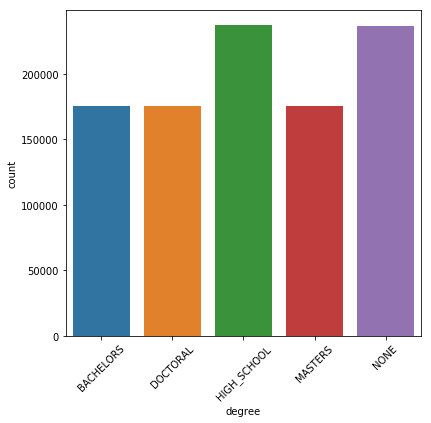

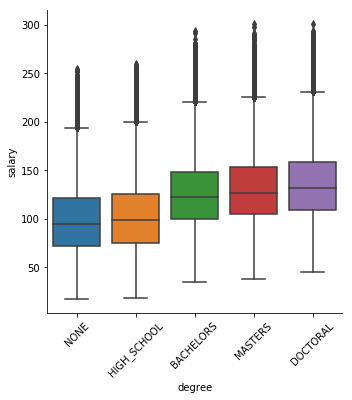

In [52]:
create_plots("degree", "salary", ['NONE', 'HIGH_SCHOOL', 'BACHELORS', 'MASTERS', 'DOCTORAL'], cleaned_training_data)

### Job Type

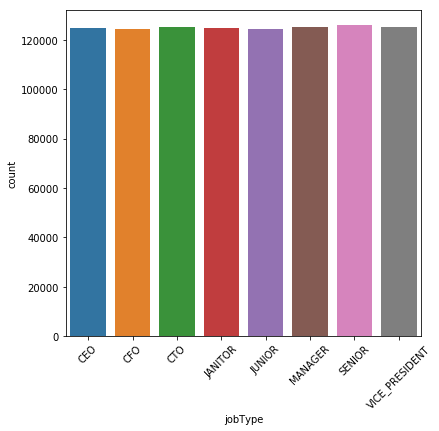

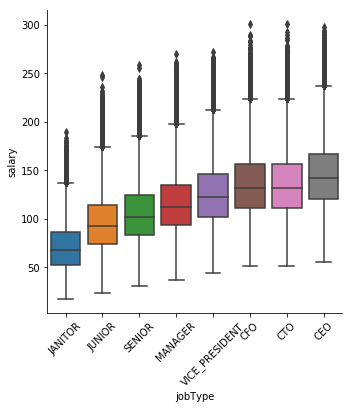

In [53]:
create_plots("jobType", "salary", ['JANITOR', 'JUNIOR', 'SENIOR', 'MANAGER', 'VICE_PRESIDENT', 'CFO', 'CTO', 'CEO'], cleaned_training_data)

### Major 

/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


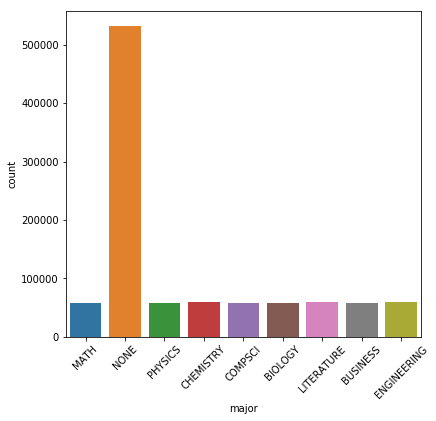

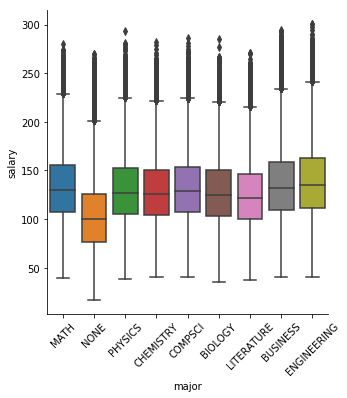

In [155]:
create_plots("major", "salary", ['MATH', 'NONE', 'PHYSICS', 'CHEMISTRY', 'COMPSCI', 'BIOLOGY', 'LITERATURE', 'BUSINESS', 'ENGINEERING'], cleaned_training_data)

### Industry

/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


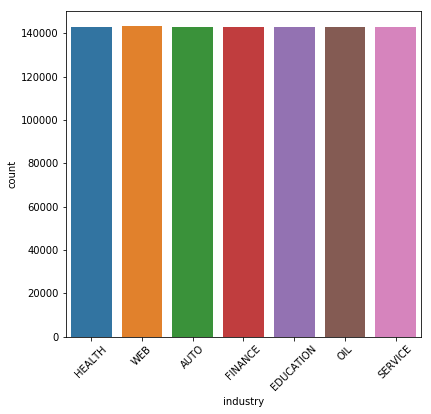

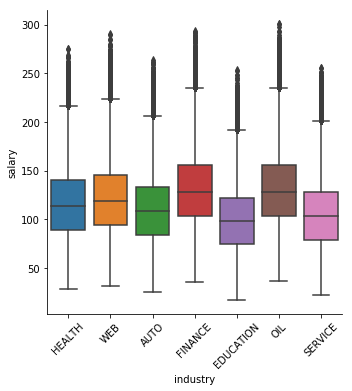

In [157]:
create_plots("industry", "salary", ['HEALTH', 'WEB', 'AUTO', 'FINANCE', 'EDUCATION', 'OIL', 'SERVICE'], cleaned_training_data)

### Write a function to plot count and relationship to salary of numeric variables.

In [54]:
def plot_line_graphs(df, x_var):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    df[x_var].value_counts().sort_index().plot()
    plt.ylabel('Counts')
    plt.xlabel(x_var)
    plt.show()
    mean = df.groupby(x_var)['salary'].mean()
    std = df.groupby(x_var)['salary'].std()
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 2)
    mean.plot()
    plt.ylabel('Salary')
    plt.xlabel(x_var)
    plt.fill_between(range(len(std.index)), mean.values + std.values, mean.values - std.values, alpha = 0.1)

### Years of Experience

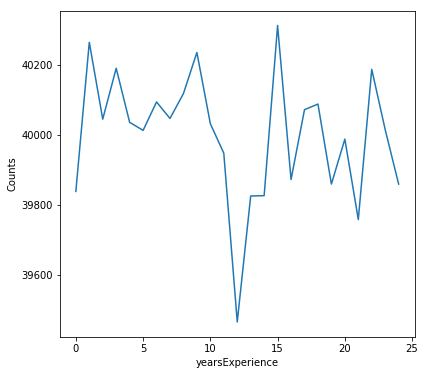

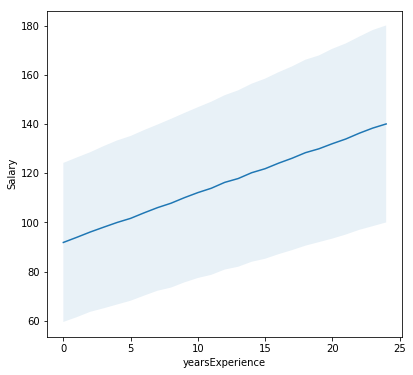

In [55]:
plot_line_graphs(cleaned_training_data, 'yearsExperience')

### Miles from Metropolis

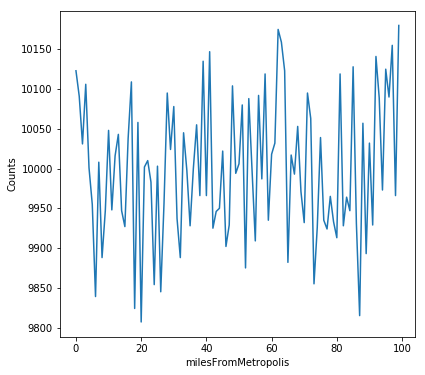

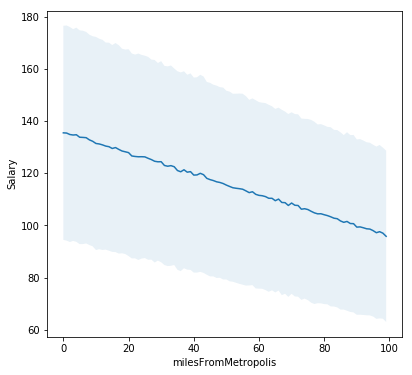

In [30]:
plot_line_graphs(cleaned_training_data, 'milesFromMetropolis')

### Company Id

KeyError: 'companyId'

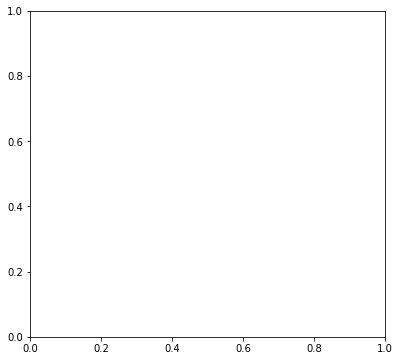

In [46]:
plot_line_graphs(cleaned_training_data, 'companyId')

### Company Id can be removed since it has no effect on salary.

In [45]:
cleaned_training_data.drop(columns = ['companyId'])

KeyError: "['companyId'] not found in axis"

### Create a correlation matrix to show which numeric variables are correlated with salary.

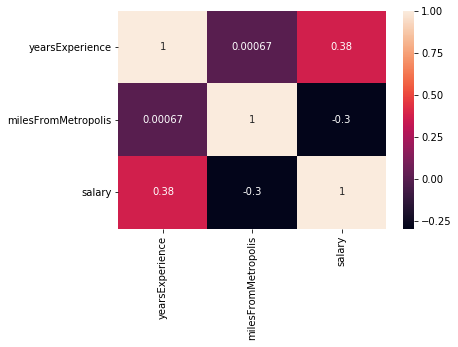

In [47]:
def create_corr_heatmap(data):
    corr = data.corr()
    sns.heatmap(corr, annot=True)

create_corr_heatmap(cleaned_training_data)

# years experience and miles from metropolis seem to have a reasonable effect on salary 

In [201]:
# encode categorical variables so they can be used in a model
# using one hot encoding so values within variables are not weighted more than one another

training_data_onehot = cleaned_training_data.copy()
training_data_onehot = pd.get_dummies(training_data_onehot, columns=categorical_columns, prefix=['type', 'degree', 'major', 'industry'])
training_data_onehot.head()

,jobId,companyId,yearsExperience,milesFromMetropolis,salary,type_CEO,type_CFO,type_CTO,type_JANITOR,type_JUNIOR,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,JOB1362684407687,COMP37,10,83,130,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,JOB1362684407688,COMP19,3,73,101,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,JOB1362684407689,COMP52,10,38,137,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,JOB1362684407690,COMP38,8,17,142,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,JOB1362684407691,COMP7,8,16,163,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


# Part 3- Develop
### Create train and test datasets.

In [204]:
salary_X = training_data_onehot.loc[:, training_data_onehot.columns != 'jobId']
salary_X = salary_X.loc[:, salary_X.columns != 'companyId']
salary_y = training_data_onehot['salary']

salary_X_train, salary_X_test, salary_y_train, salary_y_test = train_test_split(salary_X, salary_y, test_size=0.2, random_state=0)


### 4. Create a basic linear regression model as the base.

In [205]:
salary_regressor = LinearRegression()
salary_regressor.fit(salary_X_train, salary_y_train)

salary_regressor_coeff = pd.DataFrame(salary_regressor.coef_, salary_X_train.columns, columns=['Coefficient'])
print(salary_regressor_coeff)

                      Coefficient
yearsExperience     -9.322520e-15
milesFromMetropolis  1.759564e-15
salary               1.000000e+00
type_CEO            -1.149659e-02
type_CFO            -1.149659e-02
type_CTO            -1.149659e-02
type_JANITOR        -1.149659e-02
type_JUNIOR         -1.149659e-02
type_MANAGER        -1.149659e-02
type_SENIOR         -1.149659e-02
type_VICE_PRESIDENT -1.149659e-02
degree_BACHELORS     5.929659e-03
degree_DOCTORAL      5.929659e-03
degree_HIGH_SCHOOL   5.929659e-03
degree_MASTERS       5.929659e-03
degree_NONE          5.929659e-03
major_BIOLOGY        4.250906e-03
major_BUSINESS       4.250906e-03
major_CHEMISTRY      4.250906e-03
major_COMPSCI        4.250906e-03
major_ENGINEERING    4.250906e-03
major_LITERATURE     4.250906e-03
major_MATH           4.250906e-03
major_NONE           4.250906e-03
major_PHYSICS        4.250906e-03
industry_AUTO       -3.207564e-02
industry_EDUCATION  -3.207564e-02
industry_FINANCE    -3.207564e-02
industry_HEALT

### Compare the actual values for salary with the values predicted by the linear regression model.

In [72]:
# compare actual values for salary with the values predicted by the model
salary_pred = salary_regressor.predict(salary_X_test)
salary_pred_vs_actual = pd.DataFrame({'Actual': salary_y_test, 'Predicted': salary_pred})
salary_pred_vs_actual

,Actual,Predicted
157105,98,98.0
374554,103,103.0
688694,205,205.0
265381,144,144.0
955415,71,71.0
4280,59,59.0
514674,121,121.0
800352,75,75.0
94727,86,86.0
753889,91,91.0


### Evaluate the performance of the linear regression model.

In [77]:
print('Mean Absolute Error', metrics.mean_absolute_error(salary_y_test, salary_pred))
print('Mean Squared Error', metrics.mean_squared_error(salary_y_test, salary_pred))
print('Root Mean Squared Error', np.sqrt(metrics.mean_squared_error(salary_y_test, salary_pred)))
# because our error rates are so low, this means that our model is able to make very accurate predictions regarding salary

Mean Absolute Error 8.011693646177431e-14
Mean Squared Error 9.815799449633892e-27
Root Mean Squared Error 9.907471650039627e-14
